<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/yolov5_gradCAM_corneAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_GradCAM_CorneAI**

https://github.com/pooya-mohammadi/yolov5-gradcam

##**Setup YOLOv5**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git
!pip install torch
!pip install torchvision
!pip install -U opencv-python
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

/content
  Cloning https://github.com/pooya-mohammadi/deep_utils.git to /tmp/pip-req-build-6uim9rq7
  Running command git clone --filter=blob:none --quiet https://github.com/pooya-mohammadi/deep_utils.git /tmp/pip-req-build-6uim9rq7
  Resolved https://github.com/pooya-mohammadi/deep_utils.git to commit af444c93a14ba0853ec302d86a7aef63534647cc
  Preparing metadata (setup.py) ... done
  Created wheel for deep-utils: filename=deep_utils-1.3.30-py3-none-any.whl size=534934 sha256=2c18660a9f9915f91b25df0adb22d4718c313bc2cf1a2c4b9dcd01eeaf0e56a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ss487y9/wheels/8f/0a/f4/5e2b92d9573699e3e30ce319a4b06218eb281695935d0b8b54
Successfully built deep-utils
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-

In [3]:
import os
os.chdir('/content/yolov5-gradcam')

model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial/3.jpg"

In [ ]:
# !python main.py --model-path $model_path --img-path $img_path --output-dir out

#**Top3 analysis**

In [ ]:
import os
img_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
img_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit"
print(len(os.listdir(img_dir)))

235


In [ ]:
import gc
gc.collect()


26

In [ ]:
#################
#################

import numpy as np
from deep_utils.utils.box_utils.boxes import Box
import torch
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import cv2
import time
import torchvision
import torch.nn as nn
from utils.metrics import box_iou

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        # fetch the names
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        """Runs Non-Maximum Suppression (NMS) on inference and logits results

        Returns:
             list of detections, on (n,6) tensor per image [xyxy, conf, cls] and pruned input logits (n, number-classes)
        """

        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            # log_ *= x[:, 4:5]
            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                # log_ = x[:, 5:]
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):

        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    # xyxyの値を修正
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(img_size, xyxy[2])
                    xyxy[3] = min(img_size, xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img





In [ ]:
import os
import time
import numpy as np
# from models.gradcam import YOLOV5GradCAM
#from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc



# パラメータ
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
#img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/99.jpg"
#output_dir = 'out'  # 出力ディレクトリ
output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'  # 出力ディレクトリ
img_size = 640  # 入力画像サイズ
target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー
#target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
#target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
method = 'gradcam'  # 'gradcam' または 'gradcampp'
device = 'cpu'  # 'cuda' または 'cpu'

# クラス名リストを指定
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]


import time
import torch
import torch.nn.functional as F

def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    # this is a bug in cv2. It does not put box on a converted image from torch unless it's buffered and read again!
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    # Set the font size and other parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    # Calculate the text size and position
    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10  # Adjust the horizontal position to place the text near the left edge
    text_y = text_size[1] + 10  # Adjust the vertical position to place the text near the top edge

    # Put the text on the image
    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img
def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer


class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.cls_names = []  # 追加: Top1~3のクラス名を保存するリスト

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))
        # print('[INFO] saliency_map size :', self.activations['value'].shape[2:])

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        tic = time.time()
        preds, logits = self.model(input_img)
        # print("[INFO] model-forward took: ", round(time.time() - tic, 4), 'seconds')

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]  # 修正: Top1~3のクラス名を保存
        else:
            self.cls_names = []  # top3_indicesが空の場合は空のリストを代入

        for cls, cls_name in zip(preds[1][0], preds[2][0]):
            if class_idx:
                score = logits[0][0][cls]
            else:
                score = logits[0][0].max()
            self.model.zero_grad()
            tic = time.time()
            score.backward(retain_graph=True)
            # print(f"[INFO] {cls_name}, model-backward took: ", round(time.time() - tic, 4), 'seconds')
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()
            alpha = gradients.view(b, k, -1).mean(2)
            weights = alpha.view(b, k, 1, 1)
            saliency_map = (weights * activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names


    def __call__(self, input_img):
        return self.forward(input_img)

def main(img_path):
   input_size = (img_size, img_size)
   img = cv2.imread(img_path)
  #  print('[INFO] Loading the model')
   model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size,
                                     names=names)
   torch_img = model.preprocessing(img[..., ::-1])
   if method == 'gradcam':
       saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
   tic = time.time()
   masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
   print("total time:", round(time.time() - tic, 4))
   result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
   result = result[..., ::-1]  # convert to bgr
   images = [result]

   for i in range(len(masks)):
       res_img = result.copy()
       for j, mask in enumerate(masks[i]):
           bbox = boxes[0][j]
           res_img, _ = get_res_img(bbox, [mask], res_img)
           res_img = put_text_box(bbox, cls_names[i], res_img)
       images.append(res_img)

   final_image = concat_images(images)
   img_name = split_extension(os.path.split(img_path)[-1], suffix='-res')
   output_path = f'{output_dir}/{img_name}'
   os.makedirs(output_dir, exist_ok=True)
   print(f'[INFO] Saving the final image at {output_path}')
   cv2.imwrite(output_path, final_image)
   cv2_imshow(final_image)  # cv2.imwriteの代わりにcv2_imshowを使用



def folder_main(folder_path):
    input_size = (img_size, img_size)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    #################################################################
    # ファイル名を数字でソート
    file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))[127:130]
    #################################################################

    for item in file_list:
        img_path = os.path.join(folder_path, item)
        img_basename = os.path.basename(img_path)
        print(f"Processing image: {img_basename}")
        img = cv2.imread(img_path)

        # 元の画像の縦横比を維持しながらリサイズ
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = img_size, int(img_size * w / h)
        else:
            new_h, new_w = int(img_size * h / w), img_size
        img = cv2.resize(img, (new_w, new_h))

        # パディングを追加して640×640pxにする
        delta_w = img_size - new_w
        delta_h = img_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        torch_img = model.preprocessing(img[..., ::-1])

        if method == 'gradcam':
            saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
        print(f"boxes: {boxes}")

        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr
        images = [result]

        for i in range(len(masks)):
            res_img = result.copy()
            for j, mask in enumerate(masks[i]):
                bbox = boxes[0][j]
                res_img, _ = get_res_img(bbox, [mask], res_img)
                res_img = put_text_box(bbox, cls_names[i], res_img)
            images.append(res_img)

        final_image = concat_images(images)
        img_name = split_extension(os.path.split(img_path)[-1], suffix='-res')
        output_path = f'{output_dir}/{img_name}'
        os.makedirs(output_dir, exist_ok=True)
        print(f'[INFO] Saving the final image at {output_path}')
        cv2.imwrite(output_path, final_image)
        #cv2_imshow(final_image)  # cv2.imwriteの代わりにcv2_imshowを使用


        # オブジェクトを明示的に削除
        del saliency_method
        del masks
        del logits
        del boxes
        del images
        del final_image
        gc.collect()


if __name__ == '__main__':
    #target_layer = 'model_17_cv3_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_20_cv3_act'  # GradCAM を適用するレイヤー
    target_layer = 'model_23_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー  →デフォルト
    #target_layer = 'model_23_m_0_cv2_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_1'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
    img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
    #img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial"
    output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'  # 出力ディレクトリ
    if os.path.isdir(img_path):
        folder_main(img_path)
    else:
        main(img_path)

In [ ]:
import sys
sys.exit()

#**Sort GradCam Images**

GradCAM画像をクラスごとにフォルダ分け

In [ ]:
import pandas as pd

# CSVファイルのパス
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara234.csv"

# CSVファイルを読み込み
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# データフレームの最初の数行を表示
df.head()



In [ ]:
from google.colab import drive
import os
import shutil
import pandas as pd
from tqdm import tqdm

# Mount Google Drive
drive.mount('/gdrive')

# Load the Excel file
file_path = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.xlsx'
df = pd.read_excel(file_path)

# Define source and destination directories
source_dirs = [
    '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit',
    '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_sumaho'
]
destination_base_dirs = [
    '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_slit_sorted',
    '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_sumaho_sorted'
]

# Iterate over the source and destination directory pairs
for source_dir, destination_base_dir in zip(source_dirs, destination_base_dirs):
    print(f'Processing files from {source_dir} to {destination_base_dir}')
    # Iterate over the dataframe and copy files to the appropriate class folder
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        serial_number = row['serial_number']
        class_num = row['class_num']
        source_file = os.path.join(source_dir, f'{serial_number}-res.jpg')
        destination_dir = os.path.join(destination_base_dir, str(class_num))

        # Create the destination directory if it does not exist
        os.makedirs(destination_dir, exist_ok=True)

        # Copy the file to the destination directory
        destination_file = os.path.join(destination_dir, f'{serial_number}-res.jpg')
        if os.path.exists(source_file):
            shutil.copy(source_file, destination_file)
        else:
            print(f'File {source_file} does not exist.')

print('Files have been copied successfully.')


Mounted at /gdrive
Processing files from /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit to /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_slit_sorted


100%|██████████| 228/228 [00:02<00:00, 88.10it/s]


Processing files from /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_sumaho to /gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_sumaho_sorted


100%|██████████| 228/228 [00:02<00:00, 89.16it/s]

Files have been copied successfully.


#**Compare area of interest**

注目度n%以上の画像を

###**ニ値化して表示**

In [17]:
#################
#################

import numpy as np
from deep_utils.utils.box_utils.boxes import Box
import torch
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import cv2
import time
import torchvision
import torch.nn as nn
from utils.metrics import box_iou

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        # fetch the names
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        """Runs Non-Maximum Suppression (NMS) on inference and logits results

        Returns:
             list of detections, on (n,6) tensor per image [xyxy, conf, cls] and pruned input logits (n, number-classes)
        """

        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            # log_ *= x[:, 4:5]
            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                # log_ = x[:, 5:]
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):

        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    # xyxyの値を修正
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(img_size, xyxy[2])
                    xyxy[3] = min(img_size, xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


In [ ]:
import os
import time
import numpy as np
# from models.gradcam import YOLOV5GradCAM
#from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc



# パラメータ
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
#img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/99.jpg"
#output_dir = 'out'  # 出力ディレクトリ
output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'  # 出力ディレクトリ
img_size = 640  # 入力画像サイズ
target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー
#target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
#target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
method = 'gradcam'  # 'gradcam' または 'gradcampp'
device = 'cpu'  # 'cuda' または 'cpu'

# クラス名リストを指定
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]


import time
import torch
import torch.nn.functional as F

def get_res_img(bbox, masks, res_img, threshold):
    total_intersect_pixels = 0  # 共通部分のピクセル数のカウンタを初期化

    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        mask[mask < threshold*255] = 0  # 追加: 128未満の値を0にする
        mask[mask >= threshold*255] = 255  # 追加: 128未満の値を0にする
        binary_mask = mask >= threshold * 255  # 閾値を超える部分を二値化
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())

        # bboxの範囲内のマスクの部分を取得
        x1, y1, x2, y2 = bbox
        mask_bbox = binary_mask[y1:y2, x1:x2]

        # 閾値を超える共通部分のピクセル数をカウント
        intersect_pixels = np.sum(mask_bbox)
        total_intersect_pixels += intersect_pixels

        # mask_bbox のピクセル数を取得
        mask_bbox_area = mask_bbox.size

        # AOI を計算
        AOI = total_intersect_pixels / mask_bbox_area if mask_bbox_area > 0 else 0
        print(f"Area of Interest (AOI): {AOI}")

    return res_img, n_heatmat


def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    # this is a bug in cv2. It does not put box on a converted image from torch unless it's buffered and read again!
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    # Set the font size and other parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    # Calculate the text size and position
    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10  # Adjust the horizontal position to place the text near the left edge
    text_y = text_size[1] + 10  # Adjust the vertical position to place the text near the top edge

    # Put the text on the image
    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer


class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.cls_names = []  # 追加: Top1~3のクラス名を保存するリスト

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))
        # print('[INFO] saliency_map size :', self.activations['value'].shape[2:])

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        tic = time.time()
        preds, logits = self.model(input_img)
        # print("[INFO] model-forward took: ", round(time.time() - tic, 4), 'seconds')

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]  # 修正: Top1~3のクラス名を保存
        else:
            self.cls_names = []  # top3_indicesが空の場合は空のリストを代入

        for cls, cls_name in zip(preds[1][0], preds[2][0]):
            if class_idx:
                score = logits[0][0][cls]
            else:
                score = logits[0][0].max()
            self.model.zero_grad()
            tic = time.time()
            score.backward(retain_graph=True)
            # print(f"[INFO] {cls_name}, model-backward took: ", round(time.time() - tic, 4), 'seconds')
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()
            alpha = gradients.view(b, k, -1).mean(2)
            weights = alpha.view(b, k, 1, 1)
            saliency_map = (weights * activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names


    def __call__(self, input_img):
        return self.forward(input_img)

def main(img_path):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size,
                                      names=names)
    torch_img = model.preprocessing(img[..., ::-1])
    if method == 'gradcam':
        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
    tic = time.time()
    masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
    print("total time:", round(time.time() - tic, 4))
    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]  # convert to bgr
    images = [result]

    if len(masks) > 0:
        mask = masks[0][0]  # top1のマスクのみ使用
        bbox = boxes[0][0]  # top1のバウンディングボックスのみ使用
        cls_name = cls_names[0]  # top1のクラス名のみ使用
        res_img = result.copy()
        res_img, _ = get_res_img(bbox, [mask], res_img, GradCAM_threshold)
        res_img = put_text_box(bbox, cls_name, res_img)
        images.append(res_img)

    final_image = concat_images(images)
    img_name = split_extension(os.path.split(img_path)[-1], suffix='-res')
    output_path = f'{output_dir}/{img_name}'
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Saving the final image at {output_path}')
    cv2_imshow(final_image)  # cv2.imwriteの代わりにcv2_imshowを使用



def folder_main(folder_path):
    input_size = (img_size, img_size)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    ##############################################################################################
    ######## ファイル名を数字でソート#############################################################
    file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))[200:201]
    ##############################################################################################
    ##############################################################################################

    for item in file_list:
        img_path = os.path.join(folder_path, item)
        img_basename = os.path.basename(img_path)
        print(f"Processing image: {img_basename}")
        img = cv2.imread(img_path)

        # 元の画像の縦横比を維持しながらリサイズ
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = img_size, int(img_size * w / h)
        else:
            new_h, new_w = int(img_size * h / w), img_size
        img = cv2.resize(img, (new_w, new_h))

        # パディングを追加して640×640pxにする
        delta_w = img_size - new_w
        delta_h = img_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        torch_img = model.preprocessing(img[..., ::-1])

        if method == 'gradcam':
            saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
        print(f"boxes: {boxes}")

        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr
        images = [result]

        if len(masks) > 0:
            mask = masks[0][0]  # top1のマスクのみ使用
            bbox = boxes[0][0]  # top1のバウンディングボックスのみ使用
            cls_name = cls_names[0]  # top1のクラス名のみ使用
            res_img = result.copy()
            res_img, _ = get_res_img(bbox, [mask], res_img, GradCAM_threshold)
            res_img = put_text_box(bbox, cls_name, res_img)
            images.append(res_img)

        final_image = concat_images(images)
        img_name = split_extension(os.path.split(img_path)[-1], suffix='-res')
        output_path = f'{output_dir}/{img_name}'
        os.makedirs(output_dir, exist_ok=True)
        print(f'[INFO] Saving the final image at {output_path}')
        cv2_imshow(final_image)  # cv2.imwriteの代わりにcv2_imshowを使用

        # オブジェクトを明示的に削除
        del saliency_method
        del masks
        del logits
        del boxes
        del images
        del final_image
        gc.collect()


if __name__ == '__main__':
    #target_layer = 'model_17_cv3_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_20_cv3_act'  # GradCAM を適用するレイヤー
    target_layer = 'model_23_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー  →デフォルト
    #target_layer = 'model_23_m_0_cv2_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_1'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
    img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
    #img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial"
    output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'  # 出力ディレクトリ
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'  # 出力ディレクトリ

    GradCAM_threshold = 0.5 #GradCAMの閾値設定
    if os.path.isdir(img_path):
        folder_main(img_path)
    else:
        main(img_path)

###**Area of interestの計算**

結果をcsvに保存する

In [ ]:
import pandas as pd

# CSVファイルのパス
file_path = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv'

# CSVファイルをDataFrameとして読み込む
df = pd.read_csv(file_path)

# 'Unnamed'が含まれる列を削除する
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 例としてthresholdの値を設定
threshold = 0.5

# 新しい列 'AOI_{threshold}' を作成
df[f'AOI_{threshold}'] = None  # 初期値を設定

# 修正後のDataFrameを表示する
df.head()


In [4]:
#################
#################

import numpy as np
from deep_utils.utils.box_utils.boxes import Box
import torch
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import cv2
import time
import torchvision
import torch.nn as nn
from utils.metrics import box_iou

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        # fetch the names
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        """Runs Non-Maximum Suppression (NMS) on inference and logits results

        Returns:
             list of detections, on (n,6) tensor per image [xyxy, conf, cls] and pruned input logits (n, number-classes)
        """

        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            # log_ *= x[:, 4:5]
            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                # log_ = x[:, 5:]
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):

        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    # xyxyの値を修正
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                      in_source=Box.BoxSource.Torch,
                                      to_source=Box.BoxSource.Numpy,
                                      return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


In [32]:
import gc
gc.collect()

101

In [ ]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import os
from tqdm import tqdm
#from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
# from models.gradcam import YOLOV5GradCAM
import time
import torch
import torch.nn.functional as F
import gc

class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.cls_names = []  # 追加: Top1~3のクラス名を保存するリスト

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))
        # print('[INFO] saliency_map size :', self.activations['value'].shape[2:])

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        tic = time.time()
        preds, logits = self.model(input_img)
        # print("[INFO] model-forward took: ", round(time.time() - tic, 4), 'seconds')

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]  # 修正: Top1~3のクラス名を保存
        else:
            self.cls_names = []  # top3_indicesが空の場合は空のリストを代入

        for cls, cls_name in zip(preds[1][0], preds[2][0]):
            if class_idx:
                score = logits[0][0][cls]
            else:
                score = logits[0][0].max()
            self.model.zero_grad()
            tic = time.time()
            score.backward(retain_graph=True)
            # print(f"[INFO] {cls_name}, model-backward took: ", round(time.time() - tic, 4), 'seconds')
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()
            alpha = gradients.view(b, k, -1).mean(2)
            weights = alpha.view(b, k, 1, 1)
            saliency_map = (weights * activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names


    def __call__(self, input_img):
        return self.forward(input_img)

def find_yolo_layer(model, layer_name):
    """Find yolov5 layer to calculate GradCAM and GradCAM++

    Args:
        model: yolov5 model.
        layer_name (str): the name of layer with its hierarchical information.

    Return:
        target_layer: found layer
    """
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

def get_aoi(bbox, masks, threshold):
    total_intersect_pixels = 0  # 共通部分のピクセル数のカウンタを初期化

    for mask in masks:
        # マスクの前処理
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        mask[mask < threshold * 255] = 0
        mask[mask >= threshold * 255] = 255
        binary_mask = mask >= threshold * 255  # 閾値を超える部分を二値化

        # bboxの範囲内のマスク部分を取得
        x1, y1, x2, y2 = bbox
        mask_bbox = binary_mask[y1:y2, x1:x2]

        # 閾値を超える共通部分のピクセル数をカウント
        intersect_pixels = np.sum(mask_bbox)
        total_intersect_pixels += intersect_pixels

        # mask_bbox のピクセル数を取得
        mask_bbox_area = (y2 - y1) * (x2 - x1)

        # AOI を計算
        AOI = total_intersect_pixels / mask_bbox_area if mask_bbox_area > 0 else 0

    # if len(bbox) == 0 or len(masks) == 0:
    #     return 0.0

    # for mask in masks:
    #     mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
    #     mask[mask < threshold*255] = 0
    #     mask[mask >= threshold*255] = 255
    #     heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    #     n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
    #     aoi = np.sum(n_heatmat > 0) / (n_heatmat.shape[0] * n_heatmat.shape[1])
    #     print(f"Area of Interest (original_AOI): {aoi}")

    return AOI

def calculate_aoi(folder_path, csv_path, threshold, model, saliency_method, start_index=0, end_index=None):
    df = pd.read_csv(csv_path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    if f'AOI_{threshold}' not in df.columns:
        df[f'AOI_{threshold}'] = None

    if end_index is None:
        end_index = len(df)

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
        if index < start_index or index >= end_index:
            continue

        serial_number = row['serial_number']

        if pd.isna(serial_number):
            print(f"Skipping row {index} due to NaN serial_number")
            continue

        img_name = f"{int(serial_number)}.jpg"
        img_path = os.path.join(folder_path, img_name)

        # Rest of the code remains the same
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            torch_img = model.preprocessing(img[..., ::-1])

            try:
                masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
            except ValueError as e:
                print(f"Error processing image {img_name}: {str(e)}")
                continue

            if len(masks) > 0 and len(boxes) > 0:
                mask = masks[0][0]  # top1のマスクのみ使用
                bbox = boxes[0][0]  # top1のバウンディングボックスのみ使用

                aoi = get_aoi(bbox, [mask], threshold)
                df.at[index, f'AOI_{threshold}'] = aoi

                print(f"Image: {img_name}, AOI: {aoi}")
        else:
            print(f"Image not found: {img_name}")

    df.to_csv(csv_path, index=False)

# 使用例
folder_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial"
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv"
#folder_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
#csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv"
threshold = 0.5
start_index =100 # 開始するインデックスを指定
end_index = 234 # 終了するインデックスを指定

# モデルとsaliency_methodの定義
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
device = 'cpu'
input_size = (640, 640)
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
target_layer = 'model_23_cv3_conv'
saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)

calculate_aoi(folder_path, csv_path, threshold, model, saliency_method, start_index, end_index)

In [7]:
import pandas as pd

# CSVファイルのパス
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv"

# DataFrameとしてCSVファイルを読み込む
df = pd.read_csv(csv_path)

# DataFrameの最初の数行を表示する
print(df.head())


   serial_number    basename disease_English  class_num  top1  ...  top2  \
0              1   9TTR_R_01       infection          0     0  ...     3   
1              2  12TTR_R_01       infection          0     0  ...     2   
2              3  13TTR_R_01       infection          0     0  ...     2   
3              4  21TTR_L_01       infection          0     0  ...     3   
4              5  25TTR_R_01            APAC          6     6  ...     0   

   top2_prob  top3  top3_prob   AOI_0.5  
0   0.000497     2   0.000265  0.110067  
1   0.000771     1   0.000462  0.027670  
2   0.009046     3   0.003488  0.101524  
3   0.021497     8   0.011248  0.113788  
4   0.078882     8   0.003955  0.040986  

[5 rows x 11 columns]


#**注目点色塗り**

In [ ]:
#注目点に色を塗る（反転あり）
import os
import time
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc

# パラメータ
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/99.jpg"
output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'
img_size = 640
target_layer = 'model_23_cv3_act'
method = 'gradcam'
device = 'cpu'
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)
    thickness = 2

    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 10

    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.cls_names = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img)
        _, top1_idx = torch.topk(logits[0], k=1)

        if top1_idx.numel() > 0:
            preds[1][0] = top1_idx.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        cls, cls_name = preds[1][0][0], preds[2][0][0]
        if class_idx:
            score = logits[0][0][cls]
        else:
            score = logits[0][0].max()
        self.model.zero_grad()
        score.backward(retain_graph=True)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def __call__(self, input_img):
        return self.forward(input_img)

def main(img_path, threshold=0.5):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])
    if method == 'gradcam':
        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
    masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]

    if masks:
        mask = masks[0].squeeze().cpu().numpy()
        if mask.max() >= threshold:
            binary_mask = np.where(mask >= threshold, 1, 0).astype(np.uint8)
            black_mask = np.where(mask >= threshold, 0, 1).astype(np.uint8)
            binary_mask = cv2.resize(binary_mask, (result.shape[1], result.shape[0]))
            black_mask = cv2.resize(black_mask, (result.shape[1], result.shape[0]))

            color = np.array([0,0,0], dtype=np.uint8) #マスクの色：白は[0,0,0]
            masked_res_img = result * binary_mask[..., np.newaxis] + (1 - binary_mask[..., np.newaxis]) * color
            masked_res_img = (masked_res_img / masked_res_img.max()) * 255

            black_masked_res_img = result * black_mask[..., np.newaxis] + (1 - black_mask[..., np.newaxis]) * color
            black_masked_res_img = (black_masked_res_img / black_masked_res_img.max()) * 255

            cv2_imshow(masked_res_img.astype(np.uint8))
            cv2_imshow(black_masked_res_img.astype(np.uint8))

if __name__ == '__main__':
    target_layer = 'model_23_cv3_conv'
    img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial/8.jpg"
    output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'
    threshold = 0.1  # ここで閾値を指定
    if os.path.isdir(img_path):
        folder_main(img_path, threshold)
    else:
        main(img_path, threshold)


In [ ]:
# 注目点をblurする（反転あり）
import os
import time
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc

# パラメータ
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/99.jpg"
output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'
img_size = 640
target_layer = 'model_23_cv3_act'
method = 'gradcam'
device = 'cpu'
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)
    thickness = 2

    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 10

    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.cls_names = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img)
        _, top1_idx = torch.topk(logits[0], k=1)

        if top1_idx.numel() > 0:
            preds[1][0] = top1_idx.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        cls, cls_name = preds[1][0][0], preds[2][0][0]
        if class_idx:
            score = logits[0][0][cls]
        else:
            score = logits[0][0].max()
        self.model.zero_grad()
        score.backward(retain_graph=True)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def __call__(self, input_img):
        return self.forward(input_img)

def main(img_path, threshold=0.5):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])
    if method == 'gradcam':
        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size)
    masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]

    if masks:
        mask = masks[0].squeeze().cpu().numpy()
        if mask.max() >= threshold:
            binary_mask = np.where(mask >= threshold, 1, 0).astype(np.uint8)
            black_mask = np.where(mask >= threshold, 0, 1).astype(np.uint8)
            binary_mask = cv2.resize(binary_mask, (result.shape[1], result.shape[0]))
            black_mask = cv2.resize(black_mask, (result.shape[1], result.shape[0]))

            # ぼかし効果を適用
            blurred_result = cv2.GaussianBlur(result, (91, 91), 0)
            masked_res_img = result * binary_mask[..., np.newaxis] + blurred_result * (1 - binary_mask[..., np.newaxis])
            masked_res_img = (masked_res_img / masked_res_img.max()) * 255

            black_blurred_result = cv2.GaussianBlur(result, (91, 91), 0)
            black_masked_res_img = result * black_mask[..., np.newaxis] + black_blurred_result * (1 - black_mask[..., np.newaxis])
            black_masked_res_img = (black_masked_res_img / black_masked_res_img.max()) * 255

            cv2_imshow(masked_res_img.astype(np.uint8))
            cv2_imshow(black_masked_res_img.astype(np.uint8))

if __name__ == '__main__':
    target_layer = 'model_23_cv3_conv'
    img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial/41.jpg"
    output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam_img_slit'
    threshold = 0.3  # ここで閾値を指定
    if os.path.isdir(img_path):
        folder_main(img_path, threshold)
    else:
        main(img_path, threshold)


#**Analyze results**

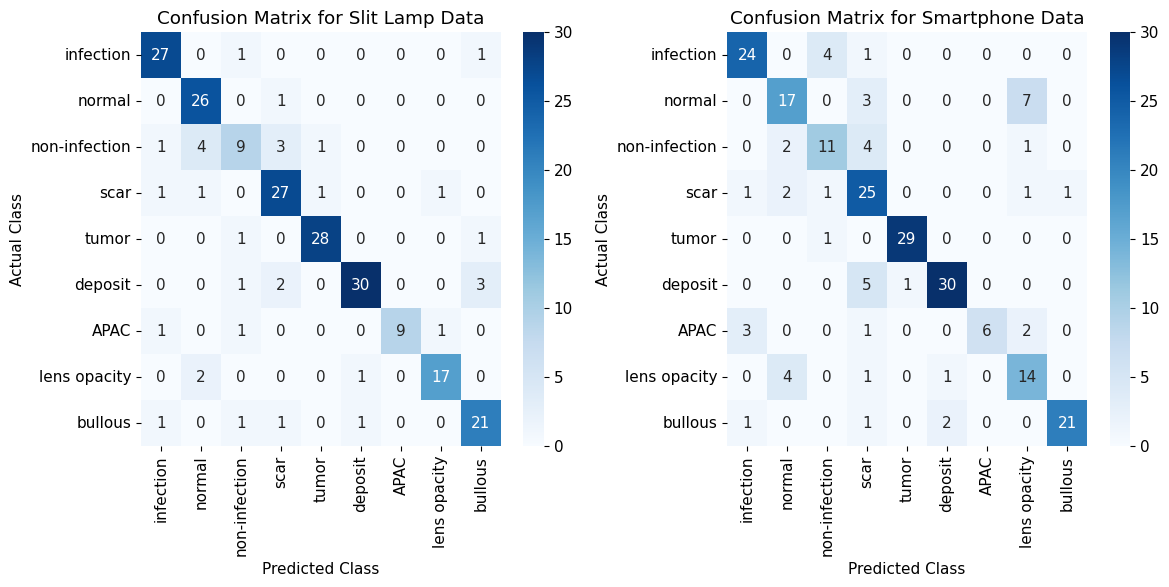

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load the CSV files
file_path1 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv'
file_path2 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv'

df_slit = pd.read_csv(file_path1)
df_sumaho = pd.read_csv(file_path2)

# Define class names
class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# Create confusion matrices for Slit and Sumaho datasets
conf_matrix_slit = pd.crosstab(df_slit['class_num'], df_slit['top1'])
conf_matrix_sumaho = pd.crosstab(df_sumaho['class_num'], df_sumaho['top1'])

# Rename the index and columns for better readability
conf_matrix_slit.index = class_names
conf_matrix_slit.columns = class_names
conf_matrix_sumaho.index = class_names
conf_matrix_sumaho.columns = class_names

# Plotting confusion matrices using seaborn
plt.figure(figsize=(12, 6))

# Slit Lamp Data Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_slit, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Slit Lamp Data')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Smartphone Data Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_sumaho, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Smartphone Data')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.tight_layout()
plt.show()


In [9]:
# Calculate accuracy for Slit and Sumaho datasets
accuracy_slit = (conf_matrix_slit.values.diagonal().sum() / conf_matrix_slit.values.sum()) * 100
accuracy_sumaho = (conf_matrix_sumaho.values.diagonal().sum() / conf_matrix_sumaho.values.sum()) * 100

accuracy_slit, accuracy_sumaho


(85.08771929824562, 77.63157894736842)

In [14]:
import pandas as pd

# ファイルパスを指定
file_path1 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv'
file_path2 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv'


# CSVファイルを読み込む
df_slit = pd.read_csv(file_path1)
df_sumaho = pd.read_csv(file_path2)

# クラス名を定義
class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# AOI_0.5の平均と標準偏差を計算
mean_sd_aoi_slit = df_slit.groupby('top1')['AOI_0.5'].agg(['mean', 'std']).reindex(range(len(class_names))).fillna(0)
mean_sd_aoi_sumaho = df_sumaho.groupby('top1')['AOI_0.5'].agg(['mean', 'std']).reindex(range(len(class_names))).fillna(0)

# インデックスにクラス名を設定
mean_sd_aoi_slit.index = class_names
mean_sd_aoi_sumaho.index = class_names

# 結果を表示
print("Mean ± SD AOI for Slit Lamp Data")
print(mean_sd_aoi_slit)
print("\nMean ± SD AOI for Smartphone Data")
print(mean_sd_aoi_sumaho)


Mean ± SD AOI for Slit Lamp Data
                   mean       std
infection      0.086643  0.037705
normal         0.050446  0.016585
non-infection  0.271836  0.145000
scar           0.205724  0.104553
tumor          0.195092  0.097643
deposit        0.072846  0.041480
APAC           0.068622  0.036099
lens opacity   0.137005  0.033883
bullous        0.126359  0.041344

Mean ± SD AOI for Smartphone Data
                   mean       std
infection      0.145351  0.055593
normal         0.114119  0.097931
non-infection  0.421066  0.225339
scar           0.358542  0.173204
tumor          0.247933  0.077559
deposit        0.172425  0.121422
APAC           0.108903  0.041468
lens opacity   0.241247  0.129700
bullous        0.191174  0.048210


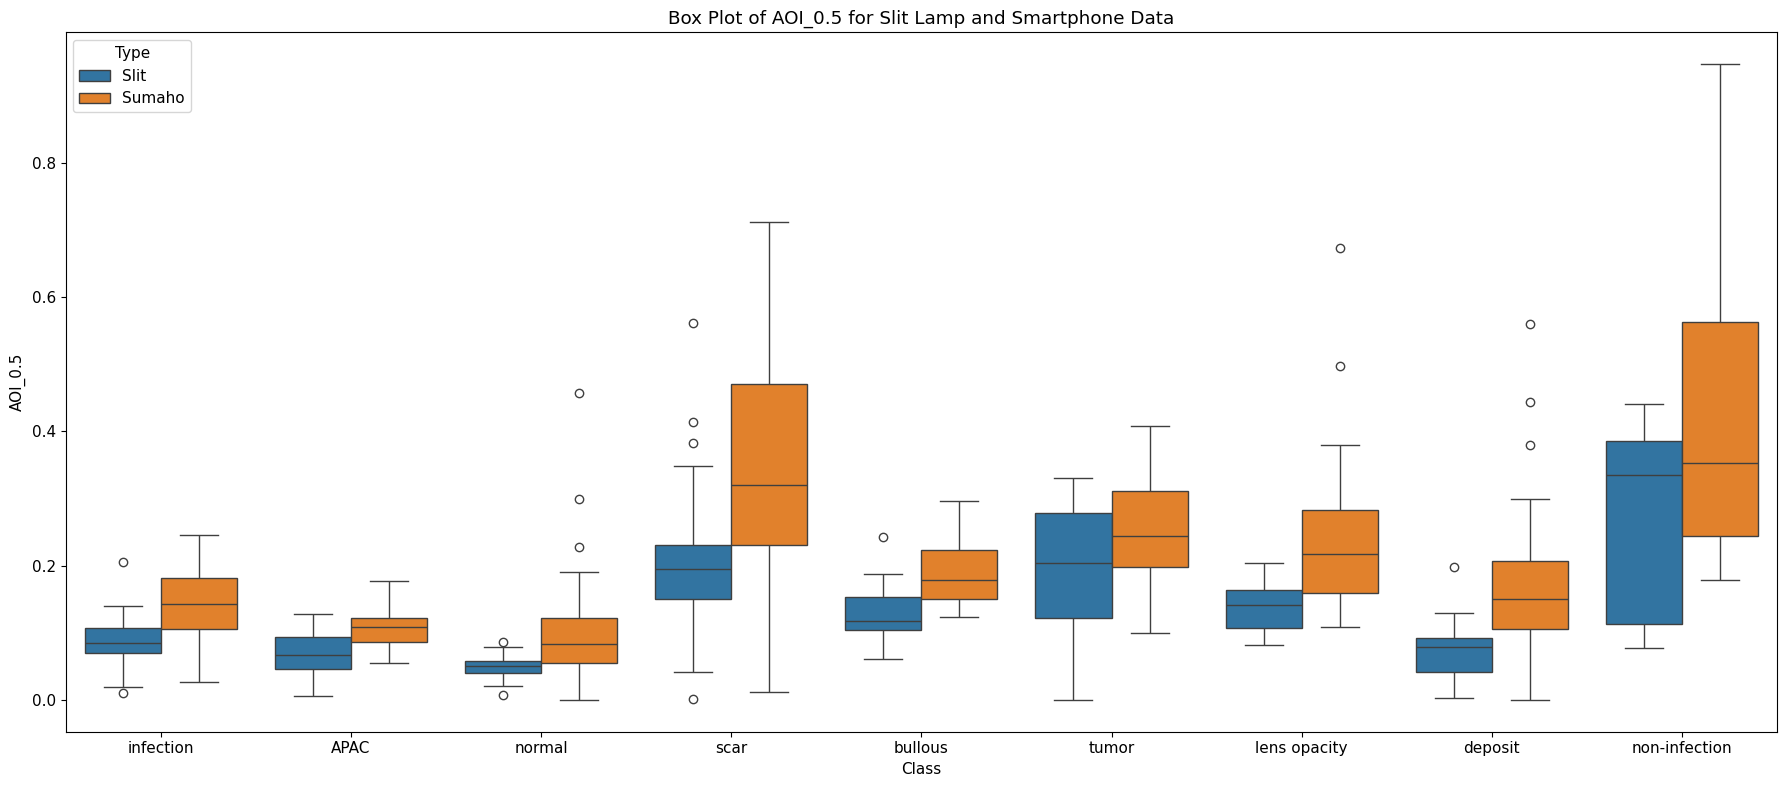

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ファイルパスを指定
file_path1 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv'
file_path2 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv'

# CSVファイルを読み込む
df_slit = pd.read_csv(file_path1)
df_sumaho = pd.read_csv(file_path2)

# クラス名を定義
class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# クラス名を数字に対応させる
df_slit['class_name'] = df_slit['top1'].map(dict(enumerate(class_names)))
df_sumaho['class_name'] = df_sumaho['top1'].map(dict(enumerate(class_names)))

# データフレームを整形してSeabornでプロットできるようにする
df_slit['Type'] = 'Slit'
df_sumaho['Type'] = 'Sumaho'

# 必要なカラムだけを選択し、欠損値を削除して結合
df_combined = pd.concat([
    df_slit[['class_name', 'AOI_0.5', 'Type']].dropna(),
    df_sumaho[['class_name', 'AOI_0.5', 'Type']].dropna()
]).reset_index(drop=True)

# グラフのサイズを設定
plt.figure(figsize=(18, 8))

# Seabornのboxplotを使用してプロット
sns.boxplot(x='class_name', y='AOI_0.5', hue='Type', data=df_combined)

# ラベルとタイトルを設定
plt.xlabel('Class')
plt.ylabel('AOI_0.5')
plt.title('Box Plot of AOI_0.5 for Slit Lamp and Smartphone Data')

# グラフを表示
plt.tight_layout()
plt.show()


In [27]:
# クラスごとに対応のあるt検定を行う
results = []
for class_name in class_names:
    slit_data = df_slit[df_slit['class_name'] == class_name]['AOI_0.5'].dropna().reset_index(drop=True)
    sumaho_data = df_sumaho[df_sumaho['class_name'] == class_name]['AOI_0.5'].dropna().reset_index(drop=True)

    # 対応のあるデータを取るため、最小の長さに合わせる
    min_length = min(len(slit_data), len(sumaho_data))
    slit_data = slit_data[:min_length]
    sumaho_data = sumaho_data[:min_length]

    t_stat, p_value = stats.ttest_rel(slit_data, sumaho_data)

    # スリットランプデータの統計値
    slit_mean = slit_data.mean()
    slit_std = slit_data.std()

    # スマートフォンデータの統計値
    sumaho_mean = sumaho_data.mean()
    sumaho_std = sumaho_data.std()

    results.append({
        'class_name': class_name,
        't_stat': t_stat,
        'p_value': p_value,
        'slit_mean': slit_mean,
        'slit_std': slit_std,
        'sumaho_mean': sumaho_mean,
        'sumaho_std': sumaho_std
    })

# 結果をデータフレームに変換して表示
df_results = pd.DataFrame(results)
df_results

,class_name,t_stat,p_value,slit_mean,slit_std,sumaho_mean,sumaho_std
0,infection,-4.924345,0.000034,0.086883,0.039013,0.145351,0.055593
1,normal,-3.137909,0.004613,0.049390,0.018775,0.114119,0.097931
2,non-infection,-1.577913,0.140569,0.271836,0.145000,0.398987,0.208018
3,scar,-4.766851,0.000037,0.205724,0.104553,0.371473,0.182324
4,tumor,-2.327765,0.027375,0.193036,0.098708,0.247933,0.077559
5,deposit,-4.511130,0.000087,0.072846,0.041480,0.175777,0.121803
6,APAC,-2.205240,0.078574,0.060506,0.035847,0.108903,0.041468
7,lens opacity,-4.519828,0.000265,0.137005,0.033883,0.274400,0.130573
8,bullous,-4.210538,0.000393,0.128439,0.044445,0.191174,0.048210


In [30]:
# 各クラスごとに対応のあるt検定を行う
results = []
for class_name in class_names:
    slit_data = df_slit[df_slit['class_name'] == class_name]['AOI_0.5'].dropna().reset_index(drop=True)
    sumaho_data = df_sumaho[df_sumaho['class_name'] == class_name]['AOI_0.5'].dropna().reset_index(drop=True)

    # 対応のあるデータを取るため、最小の長さに合わせる
    min_length = min(len(slit_data), len(sumaho_data))
    slit_data = slit_data[:min_length]
    sumaho_data = sumaho_data[:min_length]

    t_stat, p_value = stats.ttest_rel(slit_data, sumaho_data)

    # スリットランプデータの統計値
    slit_mean = slit_data.mean()
    slit_std = slit_data.std()

    # スマートフォンデータの統計値
    sumaho_mean = sumaho_data.mean()
    sumaho_std = sumaho_data.std()

    results.append({
        'class_name': class_name,
        't_stat': t_stat,
        'p_value': p_value,
        'slit_mean': slit_mean,
        'slit_std': slit_std,
        'sumaho_mean': sumaho_mean,
        'sumaho_std': sumaho_std
    })

# 全クラスまとめた対応のあるt検定
all_slit_data = df_slit['AOI_0.5'].dropna().reset_index(drop=True)
all_sumaho_data = df_sumaho['AOI_0.5'].dropna().reset_index(drop=True)

# 対応のあるデータを取るため、最小の長さに合わせる
min_length_all = min(len(all_slit_data), len(all_sumaho_data))
all_slit_data = all_slit_data[:min_length_all]
all_sumaho_data = all_sumaho_data[:min_length_all]

t_stat_all, p_value_all = stats.ttest_rel(all_slit_data, all_sumaho_data)

# 全クラスまとめた統計値
all_slit_mean = all_slit_data.mean()
all_slit_std = all_slit_data.std()
all_sumaho_mean = all_sumaho_data.mean()
all_sumaho_std = all_sumaho_data.std()

# 結果を追加
results.append({
    'class_name': 'All Classes',
    't_stat': t_stat_all,
    'p_value': p_value_all,
    'slit_mean': all_slit_mean,
    'slit_std': all_slit_std,
    'sumaho_mean': all_sumaho_mean,
    'sumaho_std': all_sumaho_std
})

# 結果をデータフレームに変換して表示
df_results = pd.DataFrame(results)
df_results['p_value'] = df_results['p_value'].map(lambda x: f'{x:.3f}')

df_results

,class_name,t_stat,p_value,slit_mean,slit_std,sumaho_mean,sumaho_std
0,infection,-4.924345,0.000,0.086883,0.039013,0.145351,0.055593
1,normal,-3.137909,0.005,0.049390,0.018775,0.114119,0.097931
2,non-infection,-1.577913,0.141,0.271836,0.145000,0.398987,0.208018
3,scar,-4.766851,0.000,0.205724,0.104553,0.371473,0.182324
4,tumor,-2.327765,0.027,0.193036,0.098708,0.247933,0.077559
5,deposit,-4.511130,0.000,0.072846,0.041480,0.175777,0.121803
6,APAC,-2.205240,0.079,0.060506,0.035847,0.108903,0.041468
7,lens opacity,-4.519828,0.000,0.137005,0.033883,0.274400,0.130573
8,bullous,-4.210538,0.000,0.128439,0.044445,0.191174,0.048210
9,All Classes,-8.849665,0.000,0.130270,0.095651,0.232668,0.156211


In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVAを実行
anova_result = stats.f_oneway(
    df_combined[df_combined['class_name'] == 'infection']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'normal']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'non-infection']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'scar']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'tumor']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'deposit']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'APAC']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'lens opacity']['AOI_0.5'],
    df_combined[df_combined['class_name'] == 'bullous']['AOI_0.5']
)

print(f"ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}")

# 事後検定（TukeyのHSD検定）を実行
tukey_result = pairwise_tukeyhsd(df_combined['AOI_0.5'], df_combined['class_name'])

# 結果を表示
print(tukey_result)

ANOVA result: F=31.54365692013175, p=3.731019510405106e-39
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
         APAC       bullous   0.0713 0.4387  -0.032  0.1746  False
         APAC       deposit   0.0387 0.9552 -0.0613  0.1387  False
         APAC     infection   0.0303 0.9907 -0.0705  0.1311  False
         APAC  lens opacity   0.1115 0.0262  0.0071  0.2159   True
         APAC non-infection   0.2717    0.0  0.1613  0.3821   True
         APAC        normal  -0.0075    1.0 -0.1088  0.0938  False
         APAC          scar   0.2045    0.0  0.1058  0.3033   True
         APAC         tumor   0.1363  0.001  0.0354  0.2373   True
      bullous       deposit  -0.0327 0.8398 -0.0991  0.0338  False
      bullous     infection   -0.041 0.6194 -0.1087  0.0266  False
      bullous  lens opacity   0.0402 0.7352 -0.0327   0.113  False
   

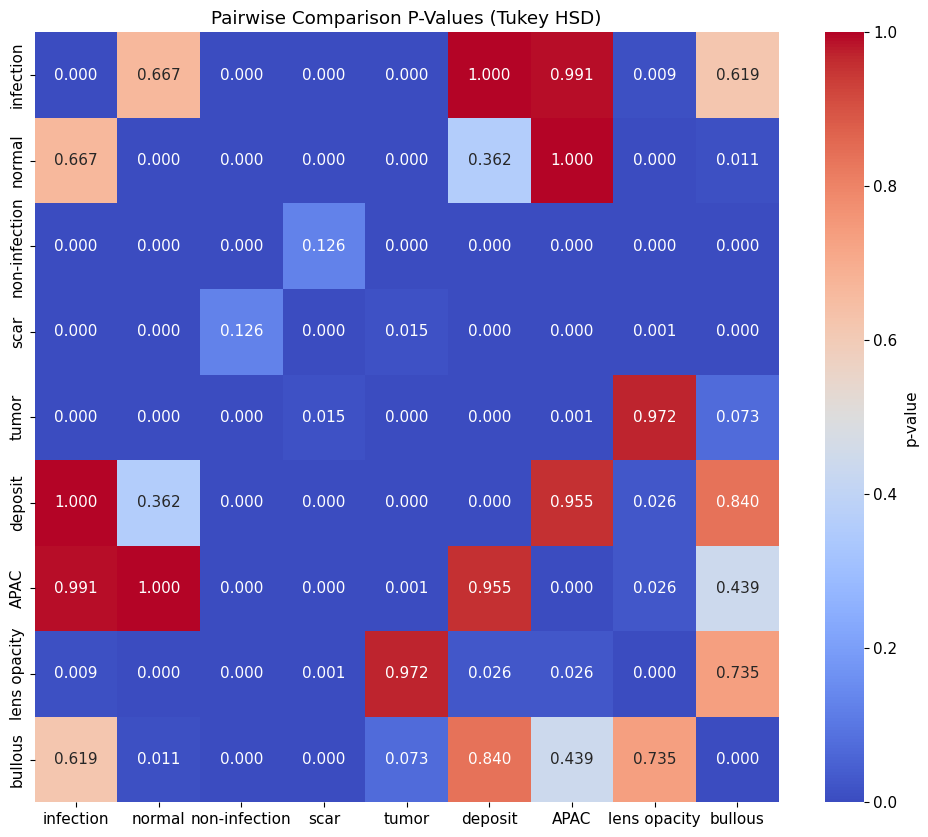

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ファイルパスを設定
file_path1 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_slit_total_updated.csv'
file_path2 = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/maehara_sumaho_total_updated.csv'

# CSVファイルを読み込む
df_slit = pd.read_csv(file_path1)
df_sumaho = pd.read_csv(file_path2)

# クラス名を定義
class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# クラス名を数字に対応させる
df_slit['class_name'] = df_slit['top1'].map(dict(enumerate(class_names)))
df_sumaho['class_name'] = df_sumaho['top1'].map(dict(enumerate(class_names)))

# データフレームを整形
df_slit['Type'] = 'Slit'
df_sumaho['Type'] = 'Sumaho'

# 必要なカラムだけを選択し、欠損値を削除して結合
df_combined = pd.concat([
    df_slit[['class_name', 'AOI_0.5', 'Type']].dropna(),
    df_sumaho[['class_name', 'AOI_0.5', 'Type']].dropna()
]).reset_index(drop=True)

# 事後検定（TukeyのHSD検定）を実行
tukey_result = pairwise_tukeyhsd(endog=df_combined['AOI_0.5'], groups=df_combined['class_name'])

# 結果をDataFrameに変換
tukey_result_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

# マトリックス図を作成するためにクラス名をインデックスとして使用
matrix = pd.DataFrame(np.zeros((len(class_names), len(class_names))), index=class_names, columns=class_names)

# マトリックスにp値を入力
for i in range(len(tukey_result_df)):
    group1 = tukey_result_df.loc[i, 'group1']
    group2 = tukey_result_df.loc[i, 'group2']
    p_value = float(tukey_result_df.loc[i, 'p-adj'])
    matrix.loc[group1, group2] = p_value
    matrix.loc[group2, group1] = p_value

# ヒートマップを描画
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-value'})
plt.title('Pairwise Comparison P-Values (Tukey HSD)')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

# CSVファイルを読み込む
df_slit = pd.read_csv(file_path1)
df_sumaho = pd.read_csv(file_path2)

# クラス名を定義
class_names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# クラス名を数字に対応させる
df_slit['class_name'] = df_slit['top1'].map(dict(enumerate(class_names)))
df_sumaho['class_name'] = df_sumaho['top1'].map(dict(enumerate(class_names)))

# データフレームを整形
df_slit['Type'] = 'Slit'
df_sumaho['Type'] = 'Sumaho'

def perform_anova_and_tukey(df, title):
    # 欠損値を削除
    df = df.dropna(subset=['AOI_0.5'])

    # ANOVAを実行
    anova_result = stats.f_oneway(
        df[df['class_name'] == 'infection']['AOI_0.5'],
        df[df['class_name'] == 'normal']['AOI_0.5'],
        df[df['class_name'] == 'non-infection']['AOI_0.5'],
        df[df['class_name'] == 'scar']['AOI_0.5'],
        df[df['class_name'] == 'tumor']['AOI_0.5'],
        df[df['class_name'] == 'deposit']['AOI_0.5'],
        df[df['class_name'] == 'APAC']['AOI_0.5'],
        df[df['class_name'] == 'lens opacity']['AOI_0.5'],
        df[df['class_name'] == 'bullous']['AOI_0.5']
    )

    print(f"{title} ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}")

    # 事後検定（TukeyのHSD検定）を実行
    tukey_result = pairwise_tukeyhsd(endog=df['AOI_0.5'], groups=df['class_name'])

    # 結果をDataFrameに変換
    tukey_result_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

    # マトリックス図を作成するためにクラス名をインデックスとして使用
    matrix = pd.DataFrame(np.zeros((len(class_names), len(class_names))), index=class_names, columns=class_names)

    # マトリックスにp値を入力
    for i in range(len(tukey_result_df)):
        group1 = tukey_result_df.loc[i, 'group1']
        group2 = tukey_result_df.loc[i, 'group2']
        p_value = float(tukey_result_df.loc[i, 'p-adj'])
        matrix.loc[group1, group2] = p_value
        matrix.loc[group2, group1] = p_value

    # 同じクラス間のセルをNaNに設定
    np.fill_diagonal(matrix.values, np.nan)

    # ヒートマップを描画
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-value'}, mask=matrix.isnull())
    plt.title(f'Pairwise Comparison P-Values (Tukey HSD) - {title}')
    plt.show()

# スリットランプデータの解析
perform_anova_and_tukey(df_slit, "Slit Lamp Data")

# スマートフォンデータの解析
perform_anova_and_tukey(df_sumaho, "Smartphone Data")